# Word2Vec from Scratch (Skip-Gram + Negative Sampling)
Pure NumPy implementation. Skip-gram with negative sampling (SGNS) trained on text8.

In [1]:
%pip install numpy matplotlib

  Using cached pillow-12.1.1-cp313-cp313-macosx_11_0_arm64.whl.metadata (8.8 kB)
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 8.1/8.1 MB 16.2 MB/s eta 0:00:00a 0:00:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.8/2.8 MB 14.3 MB/s eta 0:00:00
Using cached pillow-12.1.1-cp313-cp313-macosx_11_0_arm64.whl (4.7 MB)
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7/7 [matplotlib]7 [matplotlib]

[notice] A new release of pip is available: 25.1.1 -> 26.0.1
[notice] To update, run: pip install --upgrade pip
Note: you may need to restart the kernel to use updated packages.


## Smoke Test — Tiny Corpus
Trains on a 6-word sentence to verify the full pipeline works end-to-end.

Vocabulary size: 5
Epoch 1/100  avg_loss=2.0782  (0s)           loss=2.0782
Epoch 2/100  avg_loss=2.0773  (0s)           loss=2.0773
Epoch 3/100  avg_loss=2.0763  (0s)           loss=2.0763
Epoch 4/100  avg_loss=2.0744  (0s)           loss=2.0744
Epoch 5/100  avg_loss=2.0750  (0s)           loss=2.0750
Epoch 6/100  avg_loss=2.0760  (0s)           loss=2.0760
Epoch 7/100  avg_loss=2.0755  (0s)           loss=2.0755
Epoch 8/100  avg_loss=2.0734  (0s)           loss=2.0734
Epoch 9/100  avg_loss=2.0671  (0s)           loss=2.0671
Epoch 10/100  avg_loss=2.0690  (0s)           loss=2.0690
Epoch 11/100  avg_loss=2.0750  (0s)           loss=2.0750
Epoch 12/100  avg_loss=2.0696  (0s)           loss=2.0696
Epoch 13/100  avg_loss=2.0701  (0s)           loss=2.0701
Epoch 14/100  avg_loss=2.0768  (0s)           loss=2.0768
Epoch 15/100  avg_loss=2.0761  (0s)           loss=2.0761
Epoch 16/100  avg_loss=2.0633  (0s)           loss=2.0633
Epoch 17/100  avg_loss=2.0728  (0s)           loss=2.0728
Epoc

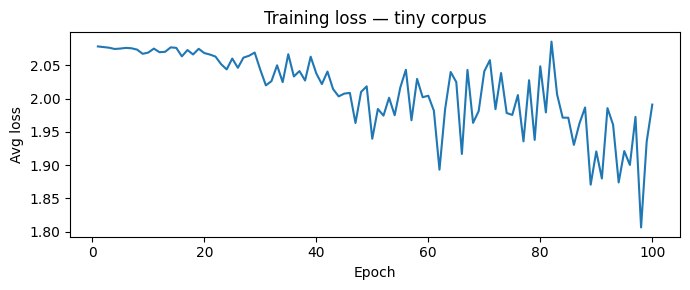

In [2]:
import matplotlib.pyplot as plt
from main import train
from evaluate import cosine_similarity

W, w2i, i2w, losses = train("the cat sat on the mat",
                             embedding_dim=5, window_size=1,
                             num_negatives=2, learning_rate=0.1,
                             num_epochs=100, min_count=1, batch_size=32)

print(f"cat ↔ on  : {cosine_similarity(W[w2i['cat']], W[w2i['on']]):.4f}  (share 2 contexts)")
print(f"cat ↔ mat : {cosine_similarity(W[w2i['cat']], W[w2i['mat']]):.4f}  (share 1 context)")

plt.figure(figsize=(7, 3))
plt.plot(range(1, len(losses) + 1), losses)
plt.xlabel("Epoch")
plt.ylabel("Avg loss")
plt.title("Training loss — tiny corpus")
plt.tight_layout()
plt.show()

## Full Training on text8
~17M tokens, vocab ~71k words. Trains in ~15–20 min on CPU.  
Saved model is loaded automatically if already trained.

Vocabulary size: 71,290
Epoch 1/10  avg_loss=2.8234  (2m 46s)          s=2.8237
Epoch 2/10  avg_loss=2.5269  (2m 58s)          s=2.5270
Epoch 3/10  avg_loss=2.4612  (2m 52s)          s=2.4612
Epoch 4/10  avg_loss=2.4290  (2m 50s)          s=2.4290
Epoch 5/10  avg_loss=2.4090  (2m 52s)          s=2.4090
Epoch 6/10  avg_loss=2.3952  (2m 56s)          s=2.3952
Epoch 7/10  avg_loss=2.3851  (2m 57s)          s=2.3851
Epoch 8/10  avg_loss=2.3756  (2m 51s)          s=2.3756
Epoch 9/10  avg_loss=2.3686  (2m 52s)          s=2.3686
Epoch 10/10  avg_loss=2.3620  (2m 53s)          s=2.3620
Model saved to model/model.npy and model/model.json


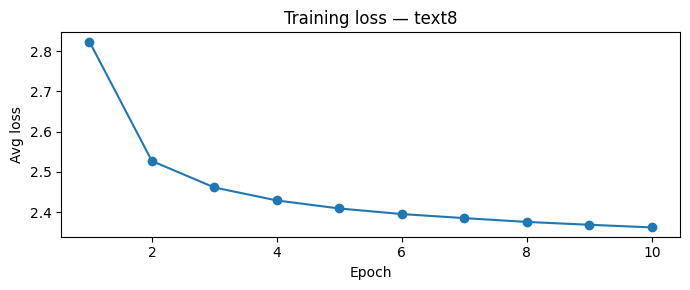

In [4]:
import os
import json
import matplotlib.pyplot as plt
from main import train, save_model, load_model

MODEL_PATH  = "model/model"      
LOSSES_PATH = "model/losses.json"
CORPUS_FILE = "text8"

os.makedirs("model", exist_ok=True)

if os.path.exists(f"{MODEL_PATH}.npy"):
    W, w2i, i2w = load_model(MODEL_PATH)
    with open(LOSSES_PATH) as f:
        losses = json.load(f)
else:
    with open(CORPUS_FILE) as f:
        corpus = f.read()
    W, w2i, i2w, losses = train(corpus, embedding_dim=100, window_size=5,
                                 num_negatives=5, learning_rate=0.025, num_epochs=10,
                                 batch_size=512)
    save_model(W, w2i, MODEL_PATH)
    with open(LOSSES_PATH, "w") as f:
        json.dump(losses, f)

plt.figure(figsize=(7, 3))
plt.plot(range(1, len(losses) + 1), losses, marker='o')
plt.xlabel("Epoch")
plt.ylabel("Avg loss")
plt.title("Training loss — text8")
plt.tight_layout()
plt.show()

## Nearest Neighbours

In [8]:
from evaluate import find_nearest, normalize_embeddings

W_normed = normalize_embeddings(W)
for word in ["computer", "france", "science", "king"]:
    if word in w2i:
        neighbours = find_nearest(word, w2i, i2w, W_normed)
        print(f"{word}: {[w for w, _ in neighbours]}")

computer: ['computers', 'hardware', 'machines', 'computing', 'applications']
france: ['french', 'paris', 'vexin', 'belgium', 'maintenon']
science: ['scientific', 'fiction', 'computer', 'contributions', 'research']
king: ['son', 'brother', 'iii', 'also', 'william']


## Analogies  (a : b :: c : ?)

In [6]:
from evaluate import analogy

tests = [("man", "king", "woman"), ("france", "paris", "england"), ("good", "better", "bad")]
for a, b, c in tests:
    if all(w in w2i for w in (a, b, c)):
        print(f"{a} : {b}  ::  {c} : {analogy(a, b, c, w2i, i2w, W_normed)}")

man : king  ::  woman : wife
france : paris  ::  england : london
good : better  ::  bad : saw


## Analogy Accuracy

In [7]:
from evaluate import eval_analogies

ANALOGY_TESTS = [
    # semantic — capitals
    ("france",   "paris",    "england",  "london"),
    ("germany",  "berlin",   "france",   "paris"),
    ("italy",    "rome",     "france",   "paris"),
    # semantic — gender
    ("man",      "king",     "woman",    "queen"),
    ("man",      "actor",    "woman",    "actress"),
    ("man",      "father",   "woman",    "mother"),
    ("man",      "brother",  "woman",    "sister"),
    # semantic — comparative
    ("good",     "better",   "bad",      "worse"),
    ("great",    "greater",  "small",    "smaller"),
    ("big",      "bigger",   "small",    "smaller"),
    # semantic — verb tense
    ("walk",     "walked",   "run",      "ran"),
    ("go",       "went",     "buy",      "bought"),
    # semantic — plurals
    ("man",      "men",      "woman",    "women"),
    ("child",    "children", "dog",      "dogs"),
]

acc, correct, total = eval_analogies(ANALOGY_TESTS, w2i, i2w, W_normed)
print(f"Analogy accuracy: {correct}/{total}  ({acc:.1%})")

Analogy accuracy: 4/14  (28.6%)
